# GNN-Based Chemical Process Analysis: Complete Workflow

This notebook demonstrates the complete workflow for training Graph Neural Networks (GNNs) to analyze and predict properties of chemical process flowsheets.

## 🎯 Two Main Capabilities

### 1. **Property Prediction** (This Notebook)
Train GNNs to predict process properties like total installed cost, energy consumption, etc.

### 2. **🆕 Graph Structure Generation** (NEW!)
Generate and predict flowsheet structures (nodes and edges):
- Generate new flowsheet designs (GraphVAE)
- Predict connections between units (Link Prediction)
- Predict unit operation types

**To see graph generation:** Run `python demo_graph_generation.py` or see `GRAPH_GENERATION_GUIDE.md`

---

## Overview: Property Prediction Workflow

This notebook covers 5 main phases:

1. **Phase 1: Data Preparation** - Load flowsheets and convert to graph representations
2. **Phase 2: Model Building** - Define the GNN architecture (Graph Attention Networks)
3. **Phase 3: Training** - Train the model with validation
4. **Phase 4: Weighted Evaluation** - Evaluate with importance-weighted scoring
5. **Phase 5: Inference & LLM Explanation** - Make predictions and generate natural language explanations


In [21]:
# Setup and imports
import os
import sys
import json
import yaml
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add src to path
sys.path.append('.')

from src.data.data_loader import FlowsheetDataLoader
from src.data.feature_extractor import FeatureExtractor
from src.data.graph_builder import FlowsheetGraphBuilder
from src.models.process_gnn import ProcessGNN
from src.training.trainer import Trainer
from src.training.utils import train_test_split_graphs
from src.evaluation.weighted_scorer import WeightedScorer
from src.inference.predictor import Predictor

# Setup plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


PyTorch version: 2.9.1
CUDA available: False


## Phase 1: Data Preparation and Graph Construction

Load flowsheet JSON files and convert them to PyTorch Geometric graph objects.


In [22]:
# Load configuration
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Load flowsheets
data_dir = config['data']['flowsheet_dir']
loader = FlowsheetDataLoader(data_dir)
flowsheets = loader.load_all_flowsheets()

print(f"Loaded {len(flowsheets)} flowsheets")
print(f"\nDataset statistics:")
stats = loader.get_statistics()
print(json.dumps(stats, indent=2))


INFO:src.data.data_loader:Found 11 flowsheet files
INFO:src.data.data_loader:Loaded: dextrose_TAL.json
INFO:src.data.data_loader:Loaded: sugarcane_succinic.json
INFO:src.data.data_loader:Loaded: corn_3HP_acrylic.json
INFO:src.data.data_loader:Loaded: sugarcane_3HP_acrylic.json
INFO:src.data.data_loader:Loaded: sugarcane_ethanol.json
INFO:src.data.data_loader:Loaded: sugarcane_TAL.json
INFO:src.data.data_loader:Loaded: sugarcane_TAL_KS.json
INFO:src.data.data_loader:Loaded: dextrose_TAL_KS.json
INFO:src.data.data_loader:Loaded: corn_succinic.json
INFO:src.data.data_loader:Loaded: dextrose_3HP_acrylic.json
INFO:src.data.data_loader:Loaded: dextrose_succinic.json
INFO:src.data.data_loader:Successfully loaded 11 flowsheets


Loaded 11 flowsheets

Dataset statistics:
{
  "num_flowsheets": 11,
  "avg_num_units": 88.0909090909091,
  "avg_num_streams": 167.9090909090909,
  "min_num_units": 54,
  "max_num_units": 127,
  "min_num_streams": 96,
  "max_num_streams": 241,
  "num_unique_unit_types": 96,
  "unique_unit_types": [
    "Acetylacetone storage tank",
    "Acidulation reactor",
    "AcrylicAcidStorageTank",
    "Aerobic digestion",
    "Air distribution package",
    "Alpha amylase tank",
    "Amine absorption",
    "An MBR",
    "Anaerobic digestion",
    "Background unit for SLE",
    "Background unit for decarboxylation",
    "Batch co fermentation",
    "Beer tank",
    "Belt thickener",
    "Biogas upgrading",
    "Boiler turbogenerator",
    "CIP Package",
    "CSL storage tank",
    "Chilled water package",
    "Clarifier",
    "Cleaning system",
    "Co fermentation",
    "Conveying belt",
    "Cooked slurry surge tank",
    "Cooling tower",
    "Corn storage",
    "Crushing mill",
    "Crystallize

In [23]:
# Extract features and build graphs
feature_extractor = FeatureExtractor()
feature_extractor.fit(flowsheets)

graph_builder = FlowsheetGraphBuilder(feature_extractor)
dataset = graph_builder.build_dataset(flowsheets, target_type='total_installed_cost')

print(f"Built {len(dataset)} graphs")
print(f"\nSample graph:")
print(f"  Nodes: {dataset[0].num_nodes}")
print(f"  Edges: {dataset[0].num_edges}")  
print(f"  Node features: {dataset[0].num_node_features}")
print(f"  Target: ${dataset[0].y.item():,.2f}")


INFO:src.data.feature_extractor:Fitted feature extractor on 11 flowsheets
INFO:src.data.feature_extractor:Found 96 unique unit types
INFO:src.data.graph_builder:Built dataset with 11 graphs


Built 11 graphs

Sample graph:
  Nodes: 73
  Edges: 80
  Node features: 6
  Target: $74,572,096.00


In [24]:
# Split data
train_dataset, val_dataset, test_dataset = train_test_split_graphs(
    dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42
)

print(f"Training: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")


INFO:src.training.utils:Split dataset: 7 train, 1 val, 3 test


Training: 7, Validation: 1, Test: 3


## Phase 2 & 3: Build and Train GNN Model

Create a Graph Attention Network and train it on the process flowsheet data.


In [25]:
# Build model
model = ProcessGNN(
    num_node_features=dataset[0].num_node_features,
    num_edge_features=dataset[0].num_edge_features if dataset[0].edge_attr is not None else 0,
    hidden_channels=64,
    num_layers=2,
    heads=4,
    dropout=0.2
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


Using device: cpu
Model parameters: 172,481


In [26]:
# Train model
trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    batch_size=8,
    learning_rate=0.001,
    device=device,
    checkpoint_dir='outputs/checkpoints'
)

history = trainer.train(num_epochs=100, early_stopping_patience=20, verbose=True)


Training:  16%|█▌        | 16/100 [00:00<00:02, 36.30it/s, train_loss=306652212438761472.0000, val_loss=15459132412788736.0000, val_mae=124334760.00, val_r2=0.0000]INFO:src.training.utils:Early stopping triggered after 20 epochs without improvement
INFO:src.training.trainer:Early stopping at epoch 21
Training:  20%|██        | 20/100 [00:00<00:02, 35.89it/s, train_loss=306652212438761472.0000, val_loss=15459132412788736.0000, val_mae=124334760.00, val_r2=0.0000]
INFO:src.training.trainer:Saved checkpoint to outputs/checkpoints/checkpoint_epoch_final.pt


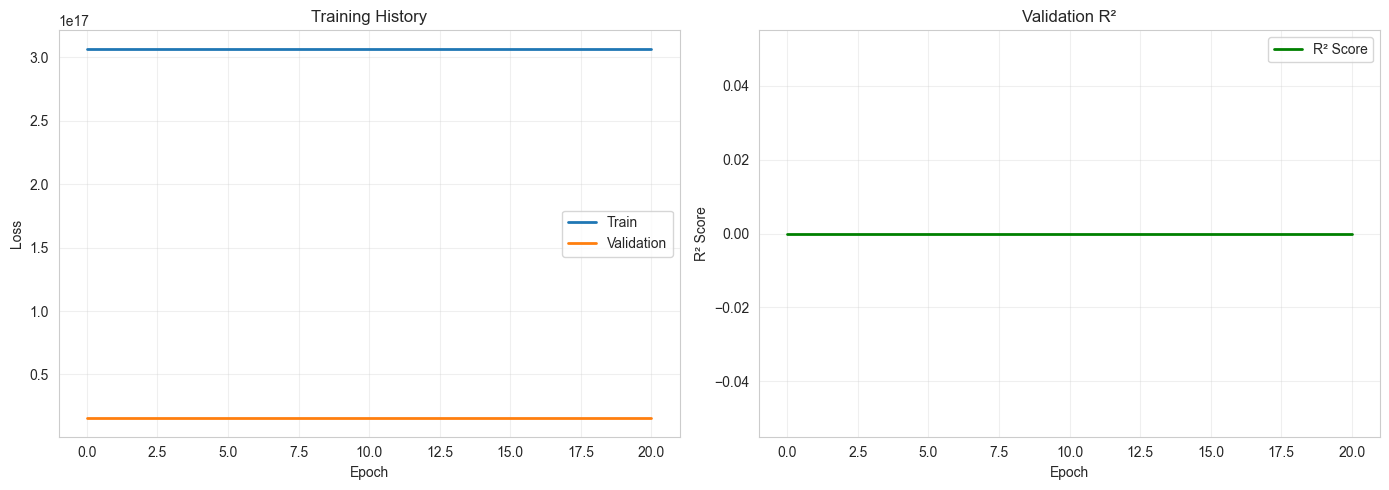

In [27]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history['train_loss'], label='Train', linewidth=2)
axes[0].plot(history['val_loss'], label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training History')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['val_r2'], label='R² Score', linewidth=2, color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('R² Score')
axes[1].set_title('Validation R²')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Phase 4: Weighted Evaluation

Evaluate the model using importance-weighted scoring based on equipment costs.


In [28]:
# Evaluate with weighted scoring
scorer = WeightedScorer(weight_by='installed_cost')
test_scores = scorer.calculate_weighted_score(model, test_dataset, device)

print("Test Set Metrics:")
print("=" * 50)
for metric, value in test_scores.items():
    print(f"{metric:20s}: {value:,.2f}")


Test Set Metrics:
MAE                 : 273,721,376.00
MSE                 : 135,785,365,293,236,224.00
RMSE                : 368,490,656.00
MAPE                : 100.00
R2                  : -1.23
Weighted_MAE        : 273,721,376.00
Weighted_MSE        : 135,785,373,883,170,816.00
Weighted_RMSE       : 368,490,656.00


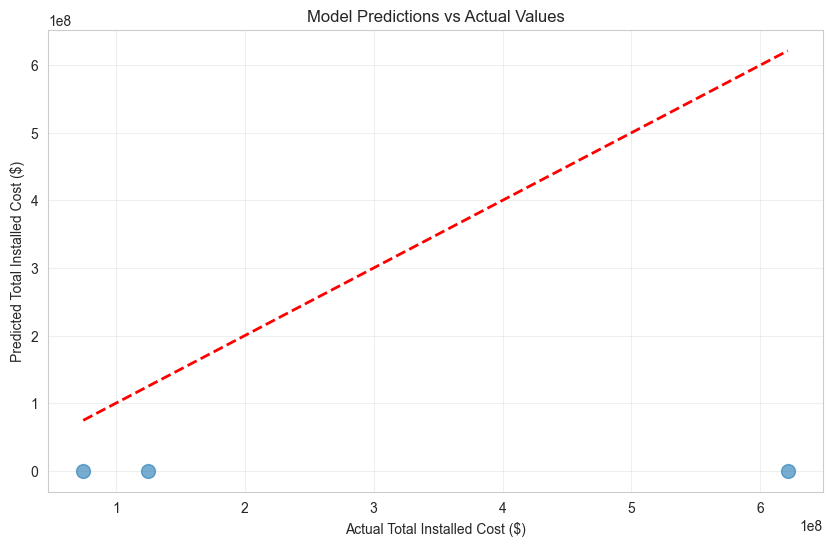

In [29]:
# Visualize predictions vs actual
predictions = trainer.predict(test_dataset)
targets = np.array([data.y.item() for data in test_dataset])

plt.figure(figsize=(10, 6))
plt.scatter(targets, predictions, alpha=0.6, s=100)
plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--', lw=2)
plt.xlabel('Actual Total Installed Cost ($)')
plt.ylabel('Predicted Total Installed Cost ($)')
plt.title('Model Predictions vs Actual Values')
plt.grid(True, alpha=0.3)
plt.show()


## Phase 5: Inference and Explanation

Make predictions and generate detailed explanations for individual processes.

**Note:** For Gemini API integration, set up Google Cloud credentials and install `google-cloud-aiplatform`.


In [30]:
# Make prediction with explanation
predictor = Predictor(model, device=device)
test_sample = test_dataset[0]
explanation = predictor.explain_prediction(test_sample, top_k_streams=5)

print("Prediction Analysis:")
print("=" * 80)
print(f"Predicted cost: ${explanation['prediction']['prediction']:,.2f}")
if 'ground_truth' in explanation['prediction']:
    print(f"Actual cost: ${explanation['prediction']['ground_truth']:,.2f}")
    print(f"Error: {explanation['prediction']['relative_error']:.2f}%")

print(f"\nProcess complexity:")
print(f"  Units: {explanation['process_complexity']['num_units']}")
print(f"  Streams: {explanation['process_complexity']['num_streams']}")

print(f"\nTop 3 important streams:")
for i, stream in enumerate(explanation['important_streams'][:3], 1):
    print(f"  {i}. Unit {stream['source_node']} → {stream['target_node']} (attention: {stream['attention_weight']:.4f})")


ERROR:src.inference.predictor:Error getting important streams: too many values to unpack (expected 2)


Prediction Analysis:
Predicted cost: $0.17
Actual cost: $74,572,096.00
Error: 100.00%

Process complexity:
  Units: 73
  Streams: 80

Top 3 important streams:


## Summary: Property Prediction

This notebook demonstrated a complete workflow for applying GNNs to chemical process **property prediction**:

✅ **Data Preparation**: Converted flowsheet JSON to graph representations  
✅ **Model Training**: Trained a Graph Attention Network  
✅ **Weighted Evaluation**: Evaluated with importance-based metrics  
✅ **Inference**: Made predictions with detailed explanations  

---

## 🆕 NEW: Graph Structure Generation

The project now also supports **generating and predicting flowsheet structures** (not covered in this notebook):

### Available Models:

1. **GraphVAE**: Generate entirely new flowsheet structures
2. **LinkPredictionGNN**: Predict connections between units
3. **NodeTypePredictor**: Predict unit operation types

### Quick Example:

```python
from src.models import GraphVAE, LinkPredictionGNN
from src.training import GraphVAETrainer

# Generate new flowsheet structures
vae = GraphVAE(num_node_features=6, latent_dim=32)
# ... train ...
new_flowsheets = vae.generate(num_graphs=10, num_nodes=50)

# Predict connections
link_model = LinkPredictionGNN(num_node_features=6)
# ... train ...
edges, probs = link_model.predict_links(partial_flowsheet)
```

### Try It:

```bash
# Run complete demo
python demo_graph_generation.py

# Read the guide
cat GRAPH_GENERATION_GUIDE.md
```

### Use Cases:
- 🎨 **Design space exploration**: Generate many candidate designs
- 🔄 **Process synthesis**: Automatic flowsheet generation
- 🔗 **Process integration**: Predict optimal connections
- 🎯 **Retrofit analysis**: Predict process modifications

---

## Next Steps

### For Property Prediction:
- Fine-tune hyperparameters (learning rate, hidden dimensions, layers)
- Try different pooling methods (max, add, attention-based)
- Implement multi-task learning for multiple targets
- Integrate Gemini API for natural language explanations

### For Graph Generation:
- Train GraphVAE on larger dataset (50+ flowsheets)
- Add chemical engineering constraints to generation
- Implement conditional generation (by product, feedstock)
- Combine with simulation for design optimization

### Resources:

- **Property Prediction**: `GNN_PROJECT_README.md`
- **Graph Generation**: `GRAPH_GENERATION_GUIDE.md`
- **Quick Start**: `QUICK_START_GUIDE.md`
- **PyTorch Geometric**: https://pytorch-geometric.readthedocs.io/
- **GAT Paper**: https://arxiv.org/abs/1710.10903
- **Project Repository**: https://github.com/sarangbhagwat/sff
